In [81]:
#tweetlerin veritabanından alınması
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import zemberek
import jpype,os
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 
durakwords= set(stopwords.words("turkish"))
import string
import re
from typing import List
from jpype import JClass, JString, getDefaultJVMPath, shutdownJVM, startJVM, java
from scipy import stats
import seaborn as sns
from collections import Counter
from keras.models import Sequential
from keras.layers import Embedding,SpatialDropout1D,LSTM,Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
%matplotlib inline
df=pd.DataFrame()
df=pd.read_csv("C:/Users/user/tweets/tweets2.csv")



In [82]:
#Tweetlerin küçük harfe dönüştürülmesi
df= df.rename(columns = {'hash,content,class': 'tweets'})
df['tweets']=df['tweets'].str.lower()

In [83]:
#tweetlerin son değerlerine göre yeni bir dataframe e yerleştirilmesi
#1 tek,2 spor,eko,pol,mag,sağ,kült
#df[df.tweets.str.endswith('2')]
df['icerik']='icerik'
df['cleantext']='cleantext'
df.loc[df['tweets'].str.endswith('1'),'icerik']="teknoloji"
df.loc[df['tweets'].str.endswith('2'),'icerik']="spor"
df.loc[df['tweets'].str.endswith('3'),'icerik']="ekonomi"
df.loc[df['tweets'].str.endswith('4'),'icerik']="politika"
df.loc[df['tweets'].str.endswith('5'),'icerik']="magazin"
df.loc[df['tweets'].str.endswith('8'),'icerik']="kultur"
df.loc[df['tweets'].str.endswith('7'),'icerik']="saglik"

In [84]:
#Zemberek kütüphanesinin kullanılabilmesi için Jpype ile JVM oluşturulması
ZEMBEREK_PATH = r'C:\Users\user\Desktop\dersler\tweets\zemberek-full.jar'
startJVM(getDefaultJVMPath(), '-ea', '-Djava.class.path=%s' % (ZEMBEREK_PATH))
#Morphology kütüphanesini kullanacağımızdan burada oluşturuyoruz
TurkishMorphology = JClass('zemberek.morphology.TurkishMorphology')
morphology = TurkishMorphology.createWithDefaults()


OSError: JVM is already started

In [85]:
def mentionRemove(text):
    text = re.sub(r'@\w+', '', text)#mentionların çıkartırılması
    return text

In [86]:
def siteRemove(text):
    text = re.sub(r'http.?://[^\s]+[\s]?', '', text)#bağlantıların çıkarılması
    return text

In [87]:
def puncRemove(text):
    text = re.sub('[^a-zığüşiöç\s]', '', text)#özel karakterlerin ve sayıların çıkarılması
    text = re.sub(r"Â", "A", text)#umlautlu karakterlerinn değiştirilmesi
    text = re.sub(r"â", "a", text)
    text = re.sub(r"Î", "I", text)
    text = re.sub(r"î", "ı", text)
    text = re.sub(r"Û", "U", text)
    text = re.sub(r"û", "u", text)

    return text

In [88]:
def removeSw(text):
    text=[w for w in tweet if w.lower() not in durakwords]#stopwordlerin çıkarılması
    return text

In [89]:
def rootFinder(text):
    pos=[]
    textlist=text.split(" ")
    analysis: java.util.ArrayList = ( morphology.analyzeAndDisambiguate(text).bestAnalysis() )
    for i, analysis in enumerate(analysis, start=1):
        f'\nAnalysis {i}: {analysis}',
        f'\nPrimary POS {i}: {analysis.getPos()}' 
        if (str(analysis.getLemmas()[0]) == "UNK"):
            pos.append(textlist[i-1])
        else:     
            pos.append(f'{str(analysis.getLemmas()[0])}')
    return pos


In [90]:
def emojiRemove(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet

In [91]:
#hash kısmının ve sondaki içerik belirteci ve tweet bağlantısının kaldırılması
#utf-16 karakterlerin elenmesi
#kelimelerin ayrıştırılması
#tweet içerisindeki bağlantıların çıkarılması
#tweet içindeki mentionların çıkarılması
p=set(string.punctuation)

def cleaner(text):
    text=text
    text=mentionRemove(text)#mentionların çıkartırılması
    text=siteRemove(text)#bağlantıların çıkarılması
    text=puncRemove(text)#özel karakterlerin ve sayıların çıkarılması
    text=emojiRemove(text)
    text=rootFinder(text)#kelime köklerinin bulunması
    text=removeSw(text)#durak kelimelerin elenmesi
    return text
for x in range(0,len(df)):
    #tweet="ve ya da için baba veya"
    tweet=df.iloc[x,0]
    tweet=mentionRemove(tweet)#mentionların çıkartırılması
    tweet=siteRemove(tweet)#bağlantıların çıkarılması
    #tweet.replace("aracılığıyla","a")
    tweet=puncRemove(tweet)#özel karakterlerin ve sayıların çıkarılması
    tweet=rootFinder(tweet)#kelime köklerinin bulunması
    tweet=removeSw(tweet)#durak kelimelerin elenmesi
    tweet=' '.join(tweet)
    #tweet=cleaner(tweet)
    df.iloc[x,2]=tweet
    pos=[]



In [92]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
df

,tweets,icerik,cleantext
0,"-9223050356879576544,son daki̇ka | futbol fede...",spor,son dakika futbol federasyon tahkim kurul beşi...
1,"-9222573041315337832,esen karol atölyesi’nin a...",kultur,esen karol atölye ardından
2,"-9222496288495997909,üniversiteler odtü´ye cep...",politika,üniversite odtü cephe al aracılığıyla
3,"-9222480792388698410,beşi̇ktaş'ın yeni yapılac...",spor,beşiktaş yeni yap stat ilgi detay sabah spor f...
4,"-9222466474619073376,cem yılmaz yeni filminin ...",magazin,cem yıl yeni film başrol ver
...,...,...,...
34995,"9210072101385251033,lg pro g2'nin bazı özellik...",teknoloji,lg pro g özellik sız
34996,"9212178017043882510,bu marka, twitter ve faceb...",teknoloji,marka twitter facebook sol sıfır bırak
34997,"9214331797304618382,turkcell müşterileri 4g'yi...",teknoloji,turkcell müşteri g deneme başla
34998,"9216183026900103052,facebook kullanan çocuklar...",teknoloji,facebook kullan çocuk mutsuz


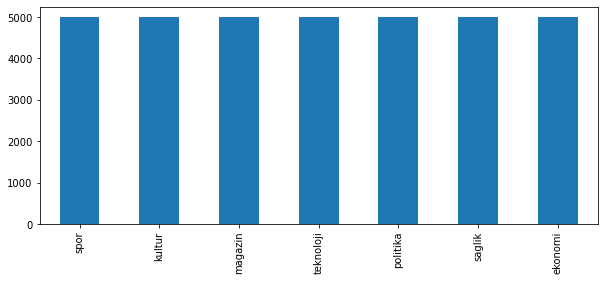

In [133]:
labels = ['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji']
plt.figure(figsize=(10,4))
df.icerik.value_counts().plot(kind='bar');

In [94]:
##Naive Bayes With Count Vectorzier
#https://github.com/Birinder1469/MultiClass_Text_Classification/blob/master/src/MultiClass_Classification.ipynb
from sklearn.metrics import classification_report,confusion_matrix

In [95]:
print(df.iloc[4,0])
print(df.iloc[4,2])

-9222466474619073376,cem yılmaz yeni filminin başrolünü kime verdi? http://t.co/s21vpmhqwd,5
cem yıl yeni film başrol ver


In [96]:
X = df.cleantext
Y = df.icerik

In [97]:
cv_counts=CountVectorizer()
x_counts=cv_counts.fit_transform(df.cleantext).toarray()
x_counts.shape

(35000, 18477)

In [98]:
X_train, X_test, Y_train, Y_test = train_test_split(x_counts, Y, test_size=0.3, random_state = 44)

In [99]:
clf_Multinomial=MultinomialNB()
clf_Multinomial.fit(X_train,Y_train)
print('The Train score for Multinomial is {0}'.format(clf_Multinomial.score(X_train,Y_train)))


The Train score for Multinomial is 0.875265306122449


In [100]:
print('The Test score for Multinomial is {0}'.format(clf_Multinomial.score(X_test,Y_test)))


The Test score for Multinomial is 0.8148571428571428


In [101]:
clf_Multinomial.predict(cv_counts.transform(["meral akşener dolar mhp ziyaret"]))

array(['politika'], dtype='<U9')

In [102]:
preds=clf_Multinomial.predict(X_test)
print("the accuracy score is ",(accuracy_score(Y_test, preds)*100))
acc_NB1=(accuracy_score(Y_test,preds)*1004)
print(classification_report(Y_test, preds,target_names=['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji']))
cr_NB1=classification_report(Y_test,preds,target_names=['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'])

the accuracy score is  81.48571428571428
              precision    recall  f1-score   support

     ekonomi       0.81      0.78      0.80      1501
      kultur       0.78      0.76      0.77      1556
     magazin       0.81      0.73      0.77      1463
    politika       0.79      0.82      0.80      1484
      saglik       0.79      0.89      0.84      1505
        spor       0.89      0.89      0.89      1463
   teknoloji       0.84      0.84      0.84      1528

    accuracy                           0.81     10500
   macro avg       0.82      0.82      0.81     10500
weighted avg       0.82      0.81      0.81     10500



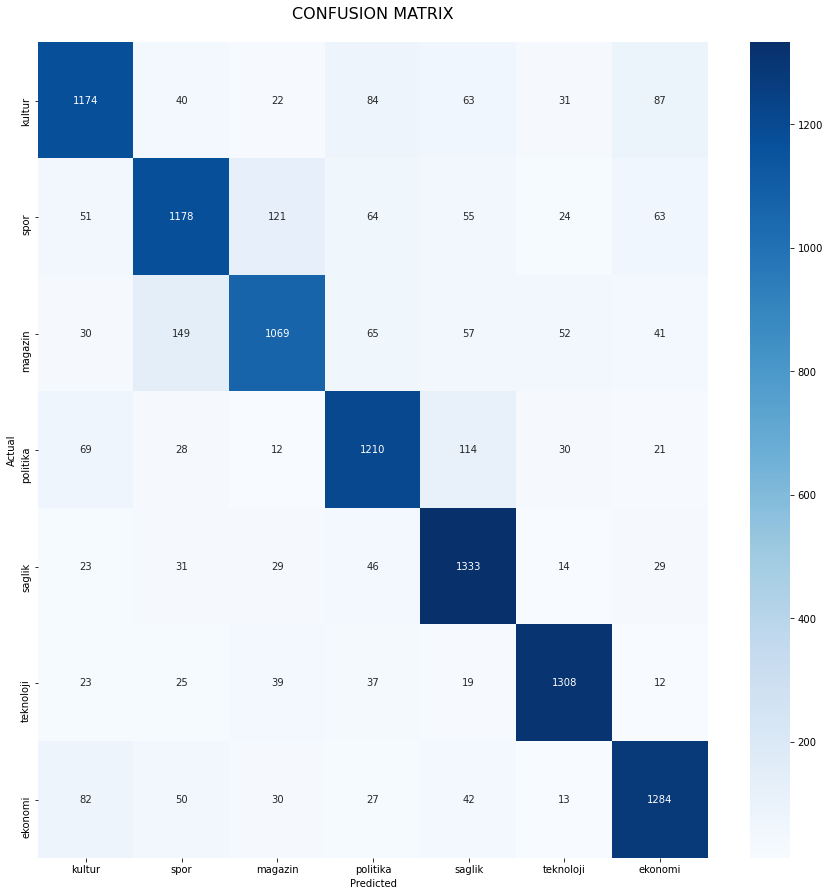

In [103]:
cm_NB1=confusion_matrix(Y_test,preds)
conf_mat = confusion_matrix(Y_test, preds)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'},
            yticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=16);

In [24]:
###Naive Bayes
##with tfidf and countvectorizer

In [25]:
bow_t=CountVectorizer().fit(df.cleantext)
bow_tweets=bow_t.transform(df.cleantext)
print(bow_tweets.shape)

(35000, 18477)


In [26]:
tfidf_transformer=TfidfTransformer().fit(bow_tweets)
print(tfidf_transformer)
tweets_tfidf=tfidf_transformer.transform(bow_tweets)
print(tweets_tfidf.shape)

TfidfTransformer()
(35000, 18477)


In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(tweets_tfidf, df.icerik, test_size=0.3, random_state = 12)

In [28]:
model=MultinomialNB().fit(X_train,Y_train)
preds=model.predict(X_test)
print(preds)

['teknoloji' 'ekonomi' 'kultur' ... 'teknoloji' 'ekonomi' 'ekonomi']


In [61]:
print('accuracy %s\n' % (accuracy_score(Y_test,preds)*100))
acc_NB2=accuracy_score(Y_test,preds)*100

accuracy 81.35238095238095



In [62]:
print(classification_report(Y_test, preds,target_names=['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji']))

              precision    recall  f1-score   support

     ekonomi       0.79      0.81      0.80      1457
      kultur       0.81      0.74      0.77      1521
     magazin       0.82      0.74      0.78      1472
    politika       0.79      0.80      0.80      1519
      saglik       0.80      0.88      0.84      1568
        spor       0.87      0.89      0.88      1521
   teknoloji       0.81      0.83      0.82      1442

    accuracy                           0.81     10500
   macro avg       0.81      0.81      0.81     10500
weighted avg       0.81      0.81      0.81     10500



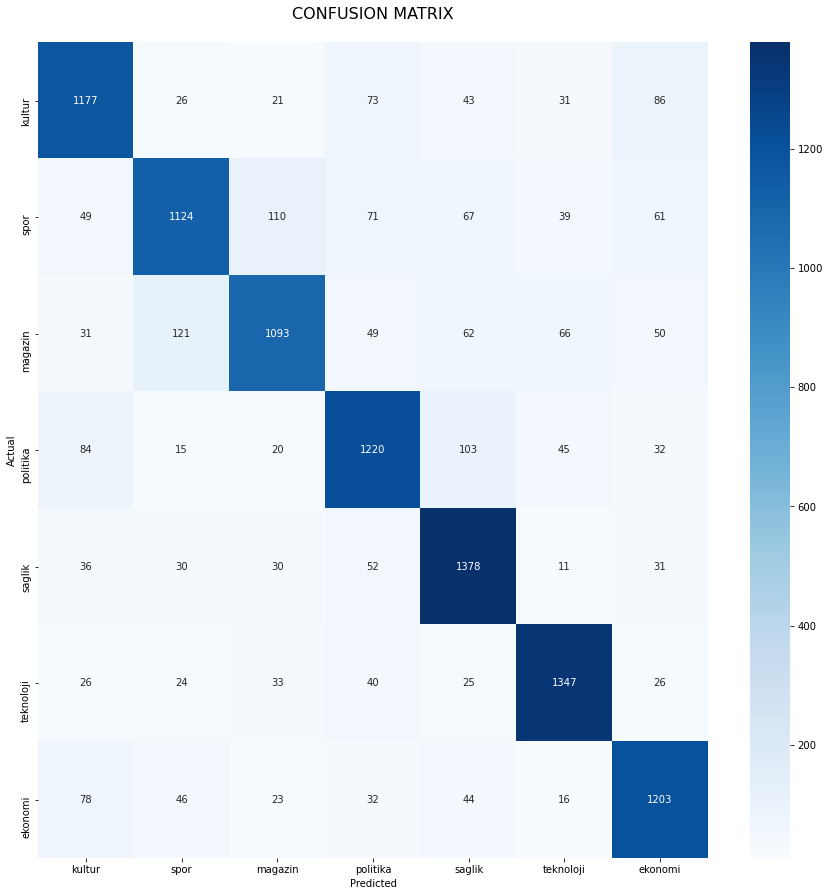

In [63]:
cr_NB2=classification_report(Y_test,preds,target_names=['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'])
cm_NB2=confusion_matrix(Y_test,preds)
cf_NB2=conf_mat
conf_mat = confusion_matrix(Y_test, preds)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'},
            yticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=16);

In [64]:
###Naive Bayes
#with tfidf with pipeline countvectorizer

In [65]:
X = df.cleantext
y = df.icerik
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 44)

In [66]:

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)
print('accuracy %s\n' % (accuracy_score(y_test, y_pred)*100))
acc_NB3=accuracy_score(y_test, y_pred)*100
print(classification_report(y_test, y_pred,target_names=['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji']))

accuracy 81.42857142857143

              precision    recall  f1-score   support

     ekonomi       0.81      0.79      0.80      1501
      kultur       0.80      0.74      0.77      1556
     magazin       0.80      0.74      0.77      1463
    politika       0.78      0.80      0.79      1484
      saglik       0.78      0.89      0.83      1505
        spor       0.89      0.90      0.89      1463
   teknoloji       0.84      0.84      0.84      1528

    accuracy                           0.81     10500
   macro avg       0.81      0.81      0.81     10500
weighted avg       0.81      0.81      0.81     10500



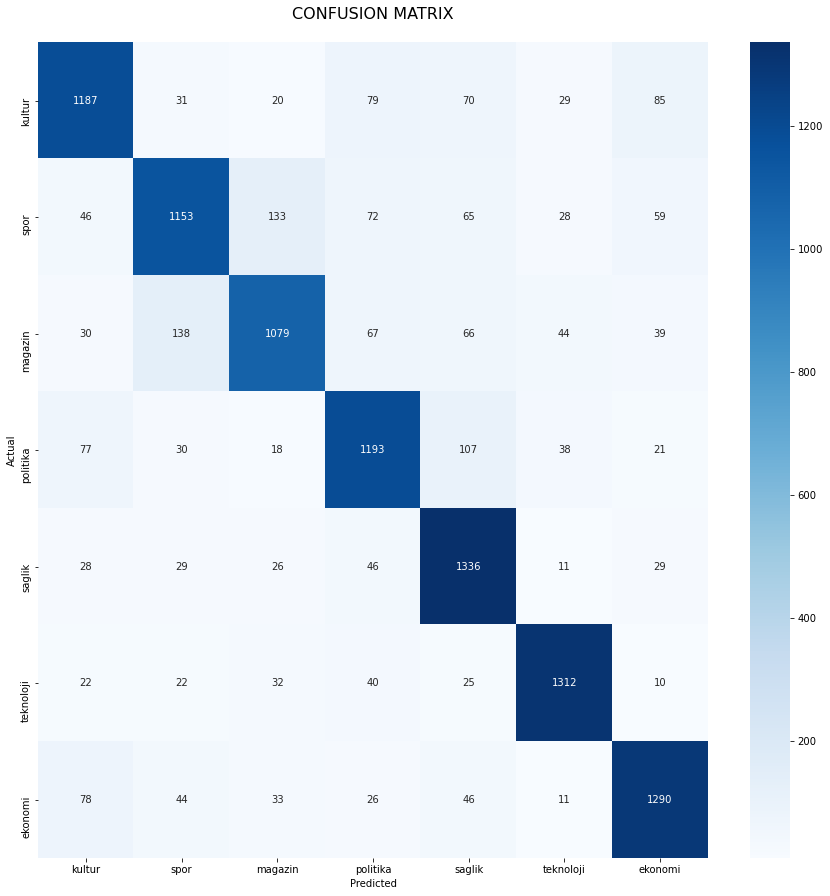

In [67]:
cr_NB3=classification_report(y_test,y_pred,target_names=['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'])
cm_NB3=confusion_matrix(y_test,y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'},
            yticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=16);


In [68]:
##Naive bayes with svm and tfidf

In [104]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['cleantext'],df['icerik'],test_size=0.3,random_state=44)
Train_X

27247                              milyon siyasi parti üye
551      sayın sağlık bakan dr mehmet müezzinoğlu mayıs...
22796    antalya kürsü baykal birlikte çık kılıçdaroğlu...
27677                                     hoffman öl söyle
32034    ezel kaya bey uyuşturucu yargıla ezel kaya bey...
                               ...                        
19183    lösemi çocuk hafta çocuk oluş hayat balık başl...
4180                                      dedikodu etki ol
25773                      chpli gü tepki sür aracılığıyla
3491     nihat doğa survivor ben hak survivor ikinci bi...
14100    yıl zaman okur haber gerçek konu şüphe duy duy...
Name: cleantext, Length: 24500, dtype: object

In [130]:
# Classifier - Algorithm - Naive Bayes
# fit the training dataset on the classifier
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)
Tfidf_vect = TfidfVectorizer(max_features=10000)
Tfidf_vect.fit(df['cleantext'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
predictions_NB = Naive.predict(Test_X_Tfidf)

In [131]:

print("NB Accuracy Score -> ",accuracy_score(Test_Y,predictions_NB)*100)
print(classification_report(Test_Y,predictions_NB,target_names=['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji']))

NB Accuracy Score ->  81.75238095238096
              precision    recall  f1-score   support

     ekonomi       0.81      0.79      0.80      1501
      kultur       0.79      0.76      0.77      1556
     magazin       0.81      0.74      0.77      1463
    politika       0.79      0.81      0.80      1484
      saglik       0.79      0.89      0.83      1505
        spor       0.89      0.89      0.89      1463
   teknoloji       0.85      0.85      0.85      1528

    accuracy                           0.82     10500
   macro avg       0.82      0.82      0.82     10500
weighted avg       0.82      0.82      0.82     10500



In [132]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', gamma='auto')
SVM=SVM.fit(Train_X_Tfidf,Train_Y)

In [128]:
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)
acc_NB4=accuracy_score(predictions_SVM, Test_Y)*100
print(classification_report(predictions_SVM, Test_Y,target_names=['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji']))
cr_NB4=classification_report(predictions_SVM, Test_Y,target_names=['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'])

SVM Accuracy Score ->  81.15238095238095
              precision    recall  f1-score   support

     ekonomi       0.83      0.75      0.79      1656
      kultur       0.78      0.74      0.76      1632
     magazin       0.77      0.72      0.74      1552
    politika       0.82      0.84      0.83      1457
      saglik       0.82      0.87      0.84      1417
        spor       0.86      0.93      0.89      1345
   teknoloji       0.82      0.87      0.84      1441

    accuracy                           0.81     10500
   macro avg       0.81      0.82      0.81     10500
weighted avg       0.81      0.81      0.81     10500



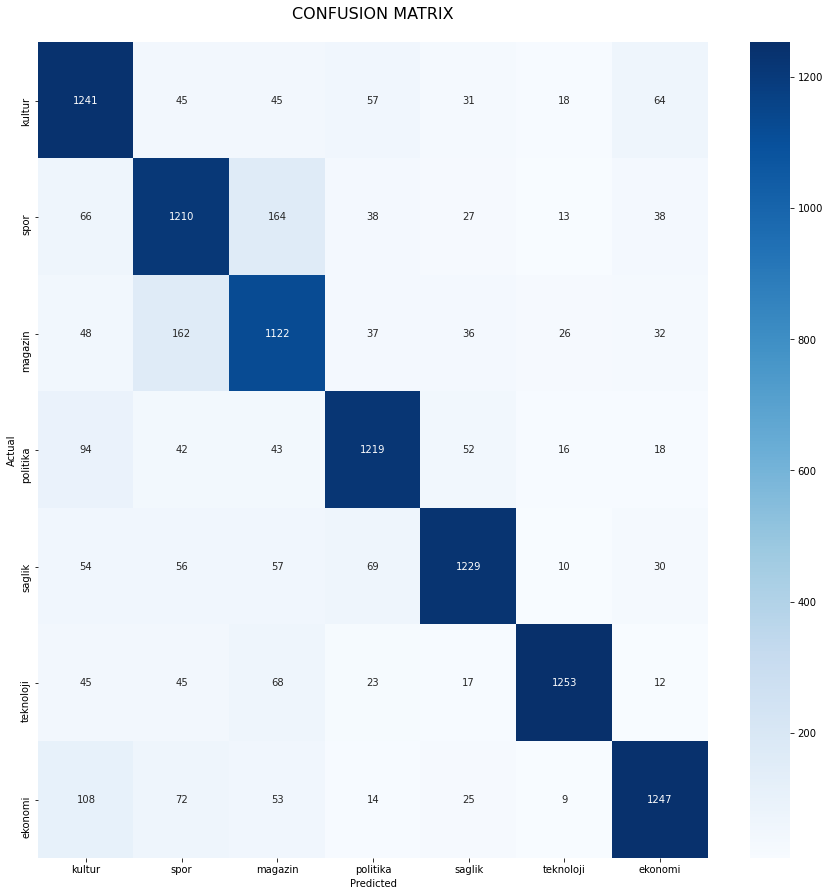

In [122]:
conf_mat = confusion_matrix(Test_Y, predictions_SVM)
cm_NB4=confusion_matrix(Test_Y,predictions_SVM)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'},
            yticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=16);

818.1165714285714
              precision    recall  f1-score   support

     ekonomi       0.81      0.78      0.80      1501
      kultur       0.78      0.76      0.77      1556
     magazin       0.81      0.73      0.77      1463
    politika       0.79      0.82      0.80      1484
      saglik       0.79      0.89      0.84      1505
        spor       0.89      0.89      0.89      1463
   teknoloji       0.84      0.84      0.84      1528

    accuracy                           0.81     10500
   macro avg       0.82      0.82      0.81     10500
weighted avg       0.82      0.81      0.81     10500



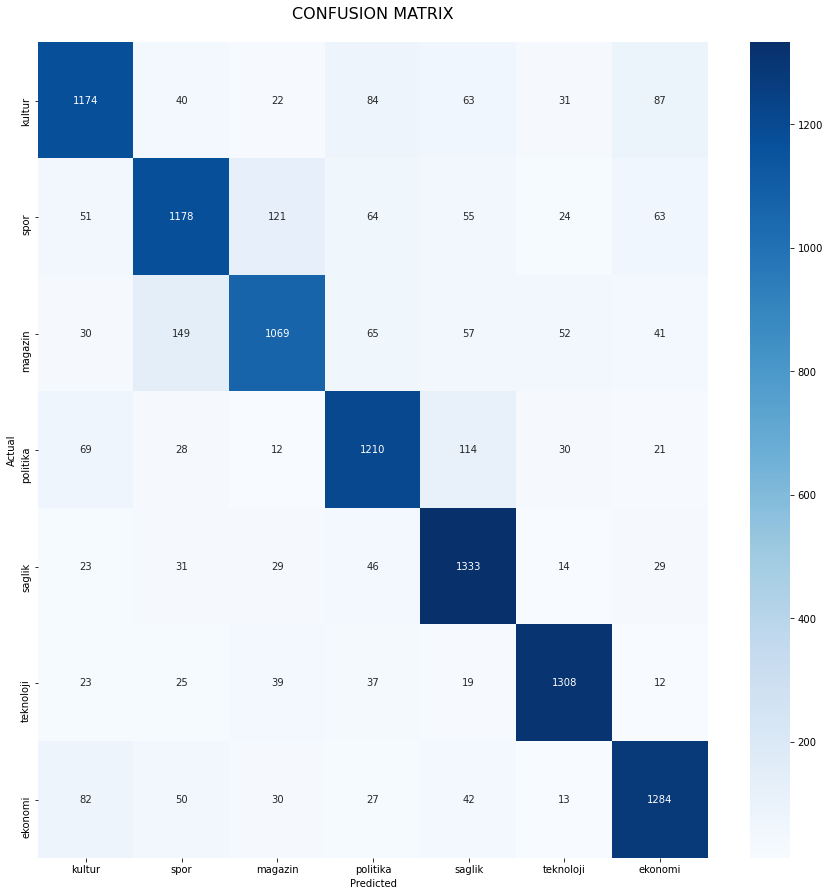

In [77]:
##NB1 Results
print(acc_NB1)
print(cr_NB1)
conf_mat=cm_NB1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'},
            yticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=16);

81.35238095238095
              precision    recall  f1-score   support

     ekonomi       0.79      0.81      0.80      1457
      kultur       0.81      0.74      0.77      1521
     magazin       0.82      0.74      0.78      1472
    politika       0.79      0.80      0.80      1519
      saglik       0.80      0.88      0.84      1568
        spor       0.87      0.89      0.88      1521
   teknoloji       0.81      0.83      0.82      1442

    accuracy                           0.81     10500
   macro avg       0.81      0.81      0.81     10500
weighted avg       0.81      0.81      0.81     10500



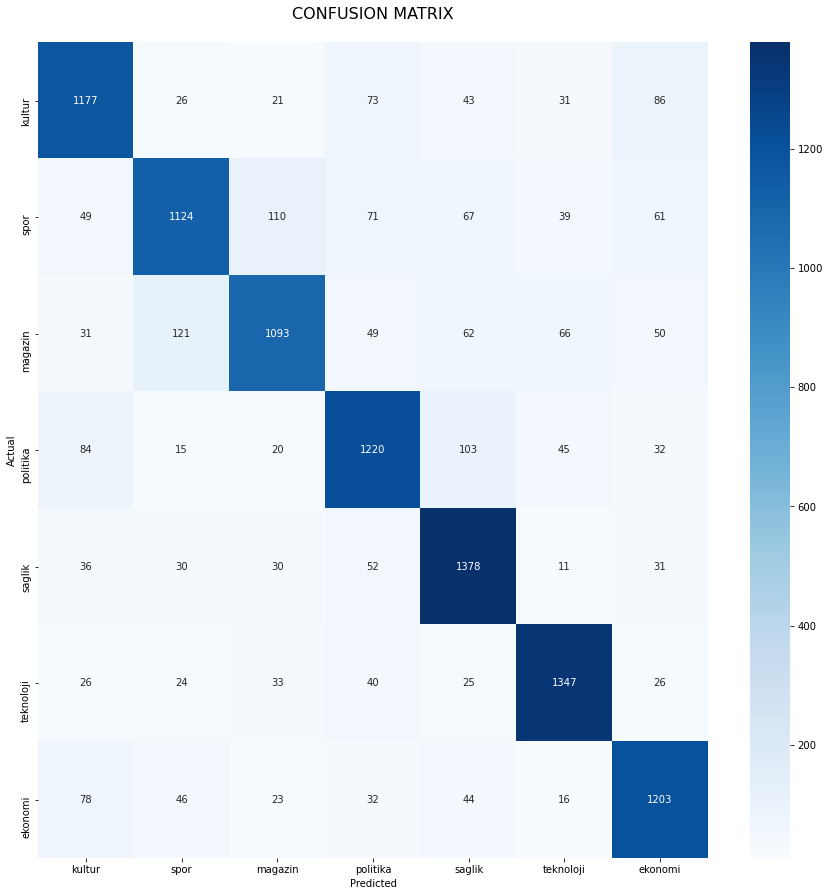

In [78]:
print(acc_NB2)
print(cr_NB2)
conf_mat=cm_NB2
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'},
            yticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=16);

81.42857142857143
              precision    recall  f1-score   support

     ekonomi       0.81      0.79      0.80      1501
      kultur       0.80      0.74      0.77      1556
     magazin       0.80      0.74      0.77      1463
    politika       0.78      0.80      0.79      1484
      saglik       0.78      0.89      0.83      1505
        spor       0.89      0.90      0.89      1463
   teknoloji       0.84      0.84      0.84      1528

    accuracy                           0.81     10500
   macro avg       0.81      0.81      0.81     10500
weighted avg       0.81      0.81      0.81     10500



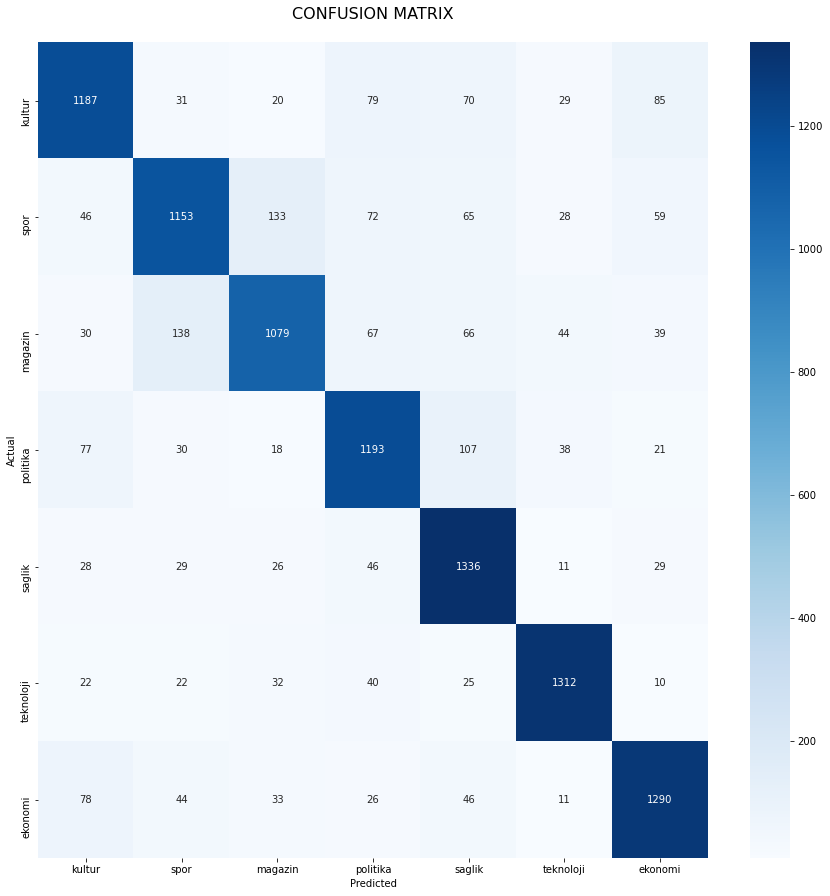

In [79]:
print(acc_NB3)
print(cr_NB3)
conf_mat=cm_NB3
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'},
            yticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=16);

81.1047619047619
              precision    recall  f1-score   support

     ekonomi       0.81      0.79      0.80      1501
      kultur       0.80      0.74      0.77      1556
     magazin       0.80      0.74      0.77      1463
    politika       0.78      0.80      0.79      1484
      saglik       0.78      0.89      0.83      1505
        spor       0.89      0.90      0.89      1463
   teknoloji       0.84      0.84      0.84      1528

    accuracy                           0.81     10500
   macro avg       0.81      0.81      0.81     10500
weighted avg       0.81      0.81      0.81     10500



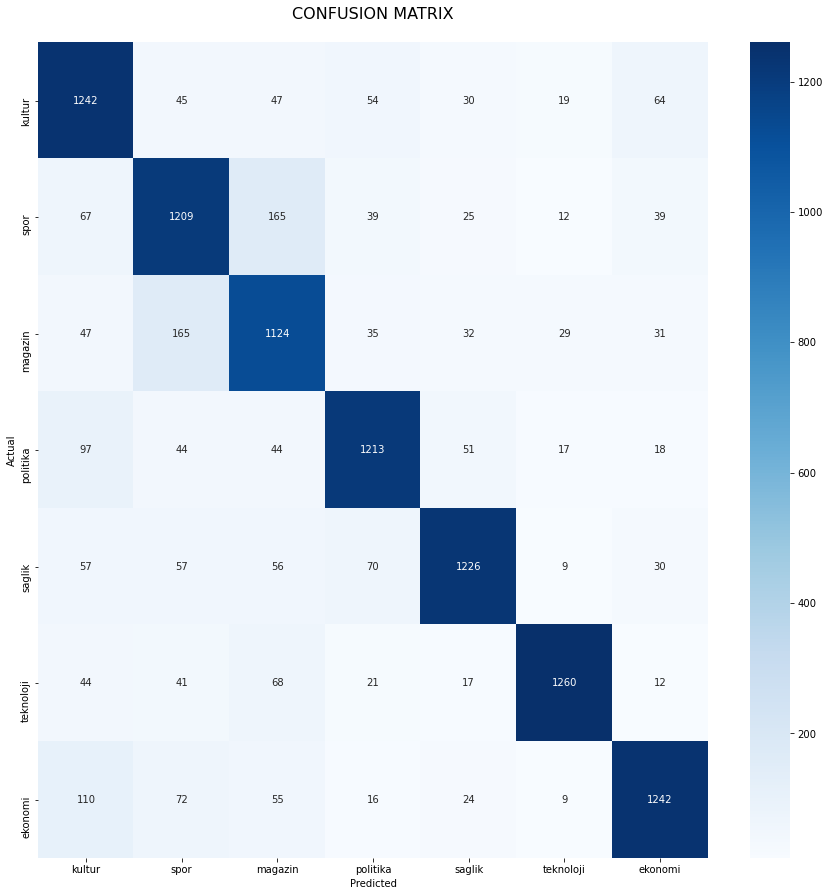

In [80]:
print(acc_NB4)
print(cr_NB4)
conf_mat=cm_NB4
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'},
            yticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=16);